<a href="https://colab.research.google.com/github/abbiereid/Student_Depression_Analysis/blob/main/StudentDepression_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Imports

In [396]:
import kagglehub
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import when, col, regexp_replace, array, desc

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.fpm import FPGrowth

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

# 2. Load Dataset

In [397]:
def init_spark(title):
    spark = SparkSession.builder.appName(title).getOrCreate()
    return spark

def create_dataframe_from_kaggle(path, session):
  path = kagglehub.dataset_download(path)
  return create_dataframe(path, session)

def create_dataframe(path, session):
  return session.read.csv(path, header=True, inferSchema=True)

In [398]:
spark = init_spark("Student Depression")
df = create_dataframe_from_kaggle("adilshamim8/student-depression-dataset", spark)

# 3. Exploratory Data Analysis




## 3.1  Data Preprocessing

### 3.1.1 Precleaned Data

In [399]:
def describeDF(df : DataFrame):
  print("Number of rows: " + str(df.count()))
  df.printSchema()

describeDF(df)

Number of rows: 27901
root
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Profession: string (nullable = true)
 |-- Academic Pressure: double (nullable = true)
 |-- Work Pressure: double (nullable = true)
 |-- CGPA: double (nullable = true)
 |-- Study Satisfaction: double (nullable = true)
 |-- Job Satisfaction: double (nullable = true)
 |-- Sleep Duration: string (nullable = true)
 |-- Dietary Habits: string (nullable = true)
 |-- Degree: string (nullable = true)
 |-- Have you ever had suicidal thoughts ?: string (nullable = true)
 |-- Work/Study Hours: double (nullable = true)
 |-- Financial Stress: string (nullable = true)
 |-- Family History of Mental Illness: string (nullable = true)
 |-- Depression: integer (nullable = true)



In [400]:
df.show()

+---+------+----+-------------+----------+-----------------+-------------+----+------------------+----------------+-------------------+--------------+----------+-------------------------------------+----------------+----------------+--------------------------------+----------+
| id|Gender| Age|         City|Profession|Academic Pressure|Work Pressure|CGPA|Study Satisfaction|Job Satisfaction|     Sleep Duration|Dietary Habits|    Degree|Have you ever had suicidal thoughts ?|Work/Study Hours|Financial Stress|Family History of Mental Illness|Depression|
+---+------+----+-------------+----------+-----------------+-------------+----+------------------+----------------+-------------------+--------------+----------+-------------------------------------+----------------+----------------+--------------------------------+----------+
|  2|  Male|33.0|Visakhapatnam|   Student|              5.0|          0.0|8.97|               2.0|             0.0|        '5-6 hours'|       Healthy|   B.Pharm|     

### 3.2.2 Cleaning data

In [401]:
def clean_data(df : DataFrame, dropColumns):
  df = df.drop(*dropColumns)

  df = df.withColumn("Depression", when(df["Depression"] == 1, "Depressed").when(df["Depression"] == 0, "Not Depressed").otherwise(None))

  df = df.withColumnRenamed("Have you ever had suicidal thoughts ?", "Suicidal Thoughts")
  df = df.withColumn("Suicidal Thoughts", when(df["Suicidal Thoughts"] == "Yes", "Has had Suicidal Thoughts").when(df["Suicidal Thoughts"] == "No", "Has not had Suicidal Thoughts").otherwise(None))

  df = df.withColumn("Family History of Mental Illness", when(df["Family History of Mental Illness"] == "Yes", "Family History of Mental Illness").when(df["Family History of Mental Illness"] == "No", "No Family History of Mental Illness").otherwise(None))

  df = df.withColumn("Dietary Habits", when(df["Dietary Habits"] == "Others", None).otherwise(df['Dietary Habits']))

  df = df.withColumn("Sleep Duration", when(df["Sleep Duration"] == "Others", None).otherwise(df['Sleep Duration']))
  df = df.withColumn("Sleep Duration", regexp_replace(df["Sleep Duration"], "[\"']", ""))

  df = df.withColumn("Financial Stress", when(df["Financial Stress"] == "?", None).otherwise((df['Financial Stress'].cast('double'))))

  df = df.withColumn("Age", df['Age'].cast('int'))

  df = df.withColumn("Degree", regexp_replace(df["Degree"], "[\"']", ""))

  return df.na.drop().dropDuplicates()

In [402]:
df = clean_data(df, ['ID', 'Work Pressure', 'Job Satisfaction', 'Profession', 'City'])

### 3.2.3 Cleaned Data

In [403]:
describeDF(df)

Number of rows: 27868
root
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Academic Pressure: double (nullable = true)
 |-- CGPA: double (nullable = true)
 |-- Study Satisfaction: double (nullable = true)
 |-- Sleep Duration: string (nullable = true)
 |-- Dietary Habits: string (nullable = true)
 |-- Degree: string (nullable = true)
 |-- Suicidal Thoughts: string (nullable = true)
 |-- Work/Study Hours: double (nullable = true)
 |-- Financial Stress: double (nullable = true)
 |-- Family History of Mental Illness: string (nullable = true)
 |-- Depression: string (nullable = true)



In [404]:
df.show()

+------+---+-----------------+----+------------------+-----------------+--------------+--------+--------------------+----------------+----------------+--------------------------------+-------------+
|Gender|Age|Academic Pressure|CGPA|Study Satisfaction|   Sleep Duration|Dietary Habits|  Degree|   Suicidal Thoughts|Work/Study Hours|Financial Stress|Family History of Mental Illness|   Depression|
+------+---+-----------------+----+------------------+-----------------+--------------+--------+--------------------+----------------+----------------+--------------------------------+-------------+
|  Male| 24|              5.0|8.74|               2.0|Less than 5 hours|     Unhealthy| B.Pharm|Has had Suicidal ...|             8.0|             4.0|            No Family History...|    Depressed|
|Female| 28|              2.0|8.95|               4.0|        5-6 hours|       Healthy|     BSc|Has had Suicidal ...|             2.0|             5.0|            Family History of...|    Depressed|
|Fema

## 3.2  Plotting functions

In [405]:
def collect_distinct_values(df : DataFrame, target, limit):
    distinct_rows = df.select(col(target)).distinct().collect()
    distinct_rows = distinct_rows[:limit]
    labels = [row[target] for row in distinct_rows]
    data = [df.filter(df[target] == label).count() for label in labels]

    return data, labels

def show_plot(plt, title):
    plt.title(title)
    plt.show()

def create_pie_chart(target, df : DataFrame, title="Pie Chart", limit=15):
    data, labels = collect_distinct_values(df, target, limit)
    plt.pie(data, labels=labels, autopct='%1.1f%%')
    show_plot(plt, title)

def create_bar_chart(target, dataframes : list[DataFrame], title="Bar Chart", limit=10, xlabel="x", ylabel="y", comparisonColumn : str = None):
    width = 0.5 / len(dataframes)

    data, labels = collect_distinct_values(dataframes[0], target, limit)
    x = np.arange(len(labels))

    for i, df in enumerate(dataframes):
      data, _ = collect_distinct_values(df, target, limit)

      if comparisonColumn:
        _, label = collect_distinct_values(df, comparisonColumn, 1)
        label = label[0]
      else:
        label = None

      plt.bar(x + width * i, data, width=width, label = label)
      if label:
        plt.legend()

    plt.xticks(x + width * (len(dataframes) - 1) / 2, labels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    show_plot(plt, title)

def create_histogram(df : DataFrame, target, title="Histogram"):
    data = [row[target] for row in df.select(target).collect()]
    plt.hist(data)
    show_plot(plt, title)

def create_network_graph(df : DataFrame, title="Network Graph", condition : callable = None):
    edges = [(str(rule["antecedent"]), str(rule["consequent"])) for rule in df.collect() if condition is None or condition(rule)]
    graph = nx.DiGraph()
    graph.add_edges_from(edges)

    pos = nx.spring_layout(graph)

    plt.figure(figsize=(15, 5))
    nx.draw(graph, pos, with_labels=True, node_size=2000, node_color='lightgreen', font_size=10)
    show_plot(plt, title)

## 3.3  Average Functions

In [406]:
def get_mean(df: DataFrame, target, roundTo):
    return round(df.select(target).groupBy().avg().collect()[0][0], roundTo)

def get_mode(df: DataFrame, target):
    return df.groupBy(target).count().orderBy(col("count").desc()).collect()[0][0]

## 3.4 Analysis

The diagram below shows that there is a higher proportion of depressed students within the dataset.

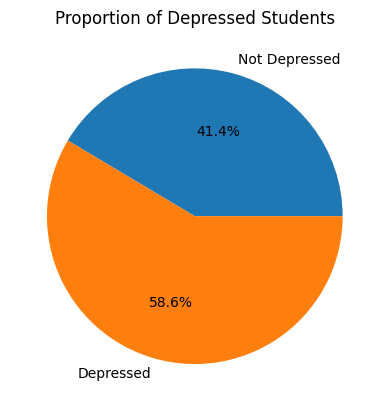

In [407]:
create_pie_chart("Depression", df, "Proportion of Depressed Students")

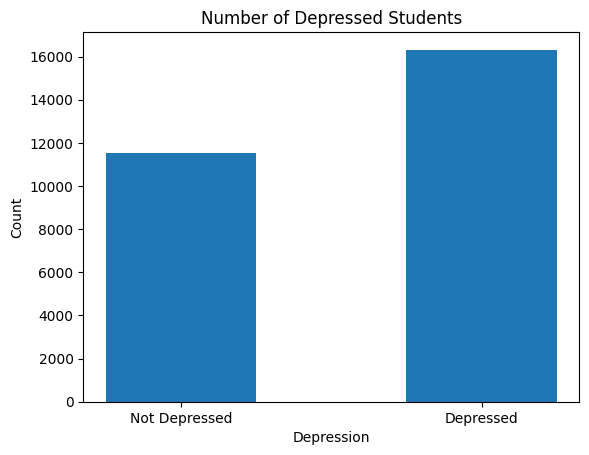

In [408]:
create_bar_chart("Depression", [df] , "Number of Depressed Students", 2, "Depression", "Count")

### Gender
This section looks at the relationships between gender and depression shown in the dataset.

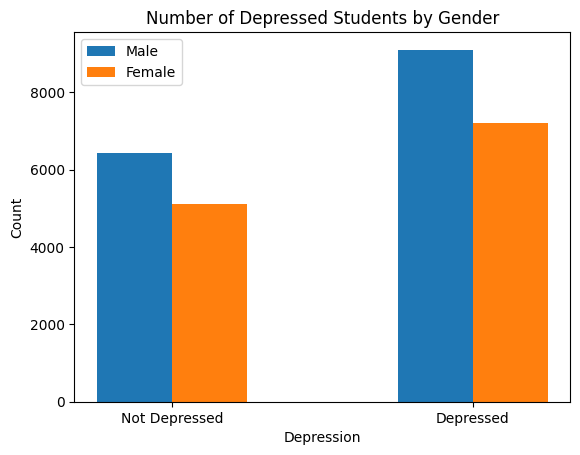

In [409]:
create_bar_chart("Depression", [df.filter(df["Gender"] == "Male"), df.filter(df["Gender"] == "Female")], "Number of Depressed Students by Gender", 2, "Depression", "Count", "Gender")

The bar chart shows that there are more depressed male students than female, but also more non-depressed males.
The three pie charts below put this into perspective, the proportion of depression amongst males and females is near enough equal, with only 0.1% of a difference. There are just more males within the dataset, so the total number of depressed males is larger.

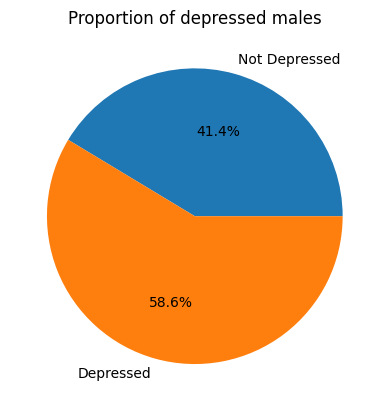

In [410]:
create_pie_chart("Depression", df.filter(df["Gender"] == "Male"), "Proportion of depressed males")

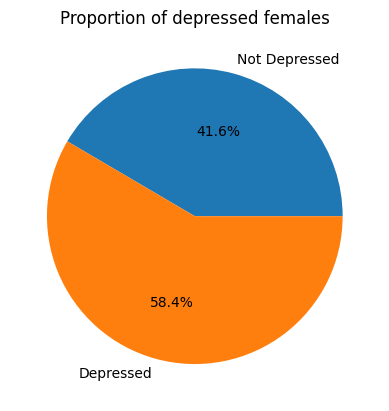

In [411]:
create_pie_chart("Depression", df.filter(df["Gender"] == "Female"), "Proportion of depressed females")

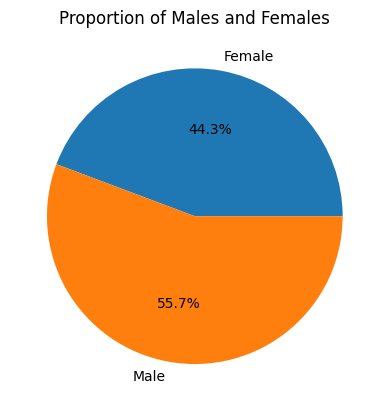

In [412]:
create_pie_chart("Gender", df, "Proportion of Males and Females")

### Age
This section shows the relationship between age and depression within the dataset.

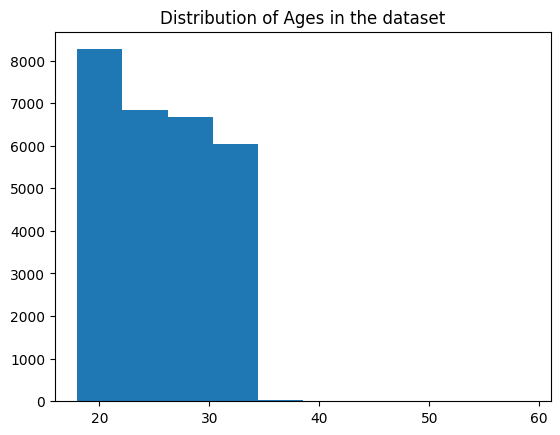

In [413]:
create_histogram(df, "Age", "Distribution of Ages in the dataset")

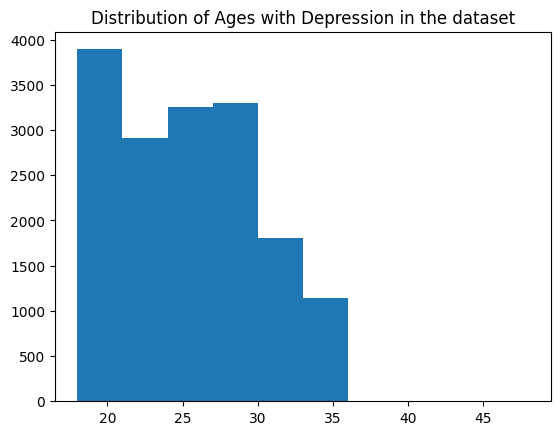

In [414]:
create_histogram(df.filter(df["Depression"] == "Depressed"), "Age", "Distribution of Ages with Depression in the dataset")

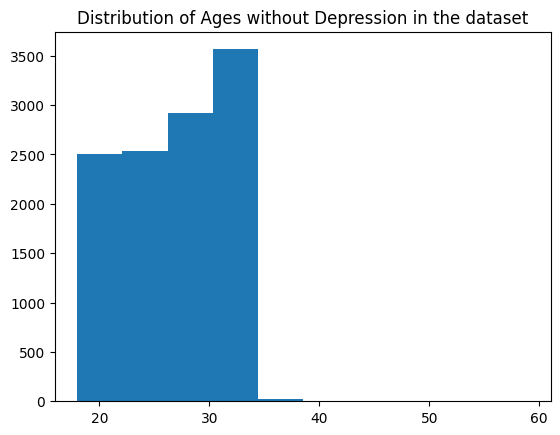

In [415]:
create_histogram(df.filter(df["Depression"] == "Not Depressed"), "Age", "Distribution of Ages without Depression in the dataset")

In [416]:
print(f"Mean Age: {get_mean(df, 'Age', 0)}")
print(f"Mode Age: {get_mode(df, 'Age')}")

Mean Age: 26.0
Mode Age: 24


In [417]:
depressedDF = df.filter(df['Depression'] == "Depressed")
notDepressedDF = df.filter(df['Depression'] == "Not Depressed")

print(f"Mean Depressed Age: {get_mean(depressedDF, 'Age', 0)}")
print(f"Mode Depressed Age: {get_mode(depressedDF, 'Age')}")

Mean Depressed Age: 25.0
Mode Depressed Age: 20


In [418]:
print(f"Mean Not Depressed Age: {get_mean(notDepressedDF, 'Age', 0)}")
print(f"Mode Not Depressed Age: {get_mode(notDepressedDF, 'Age')}")

Mean Not Depressed Age: 27.0
Mode Not Depressed Age: 33


### Stress
This section shows the relationships between the different types of stress within the dataset and depression

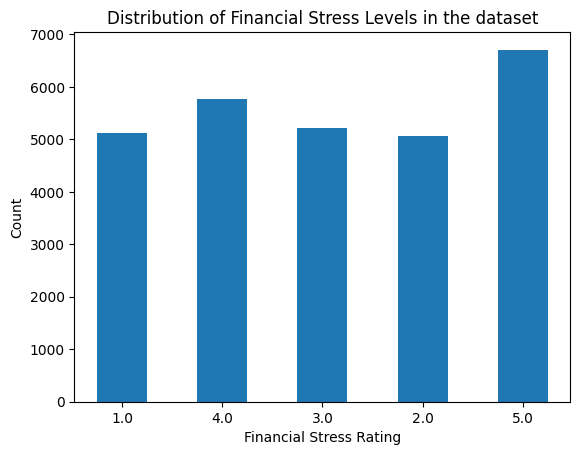

In [419]:
create_bar_chart("Financial Stress", [df] ,"Distribution of Financial Stress Levels in the dataset", xlabel="Financial Stress Rating", ylabel="Count")

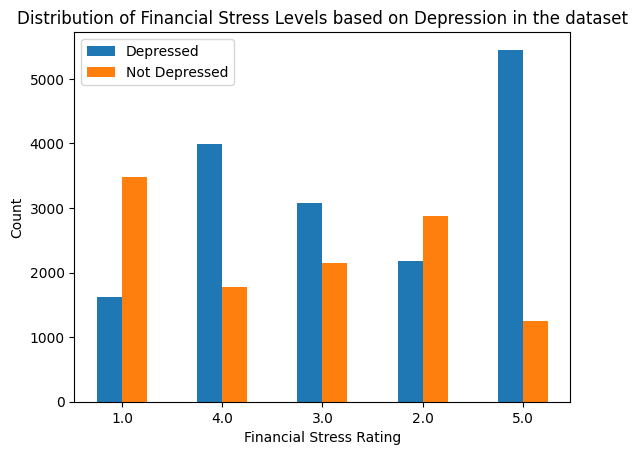

In [420]:
create_bar_chart("Financial Stress", [df.filter(df['Depression'] == "Depressed"), df.filter(df['Depression'] == "Not Depressed")] ,"Distribution of Financial Stress Levels based on Depression in the dataset", xlabel="Financial Stress Rating", ylabel="Count", comparisonColumn="Depression")

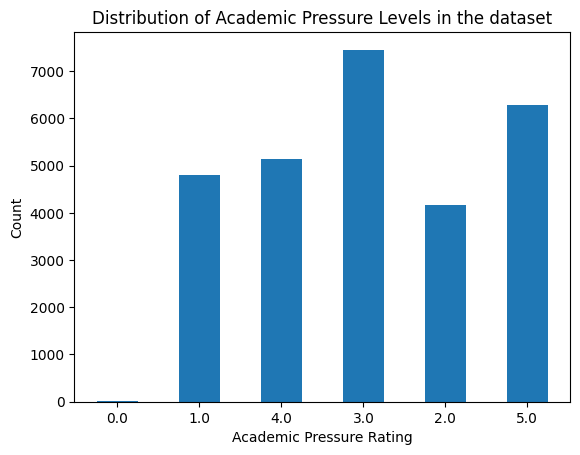

In [421]:
create_bar_chart("Academic Pressure", [df],  "Distribution of Academic Pressure Levels in the dataset", xlabel="Academic Pressure Rating", ylabel="Count")

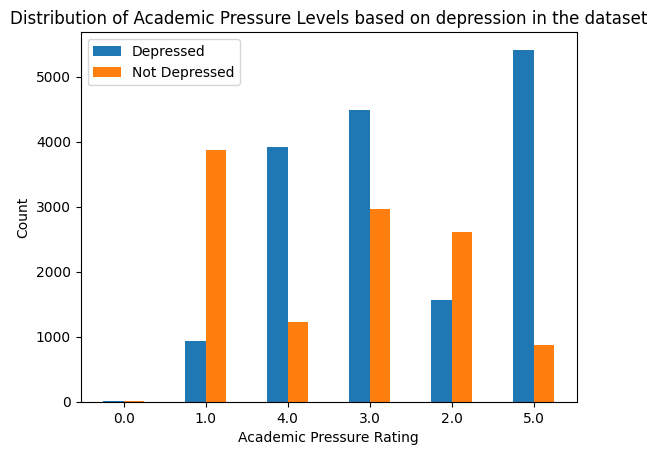

In [422]:
create_bar_chart("Academic Pressure", [df.filter(df['Depression'] == "Depressed"), df.filter(df['Depression'] == "Not Depressed")],  "Distribution of Academic Pressure Levels based on depression in the dataset", xlabel="Academic Pressure Rating", ylabel="Count" , comparisonColumn="Depression")

### Degree

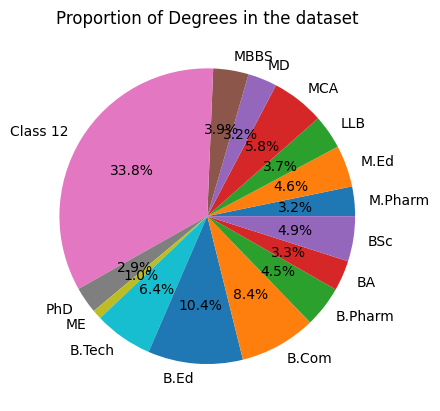

In [423]:
create_pie_chart("Degree", df, "Proportion of Degrees in the dataset")

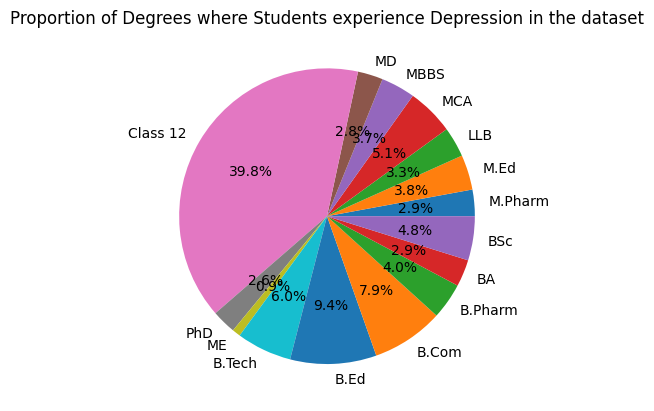

In [424]:
create_pie_chart("Degree", df.filter(df["Depression"] == "Depressed"), "Proportion of Degrees where Students experience Depression in the dataset")

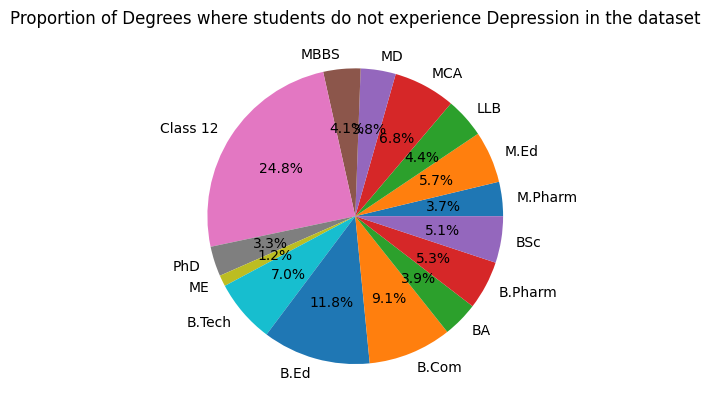

In [425]:
create_pie_chart("Degree", df.filter(df["Depression"] == "Not Depressed"), "Proportion of Degrees where students do not experience Depression in the dataset")

## 3.5 Final Cleaning

In [426]:
df = df.drop("Degree")

In [427]:
describeDF(df)

Number of rows: 27868
root
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Academic Pressure: double (nullable = true)
 |-- CGPA: double (nullable = true)
 |-- Study Satisfaction: double (nullable = true)
 |-- Sleep Duration: string (nullable = true)
 |-- Dietary Habits: string (nullable = true)
 |-- Suicidal Thoughts: string (nullable = true)
 |-- Work/Study Hours: double (nullable = true)
 |-- Financial Stress: double (nullable = true)
 |-- Family History of Mental Illness: string (nullable = true)
 |-- Depression: string (nullable = true)



# 4. Association Rule Mining


In [428]:
def prepare_for_association(df : DataFrame):
  categoricalDF = df.withColumn(
      "Financial Stress",
      when(df["Financial Stress"] <= 2, "Low Financial Stress")
      .when(df["Financial Stress"] == 3, "Moderate Financial Stress")
      .otherwise("High Financial Stress")
  )

  categoricalDF = categoricalDF.withColumn(
      "Academic Pressure",
      when(categoricalDF["Academic Pressure"] <= 2, "Low Academic Pressure")
      .when(categoricalDF["Academic Pressure"] == 3, "Moderate Academic Pressure")
      .otherwise("High Academic Pressure")
  )

  categoricalDF = categoricalDF.withColumn(
      "items",
      array(
          "Sleep Duration",
          "Dietary Habits",
          "Financial Stress",
          "Academic Pressure",
          "Suicidal Thoughts",
          "Family History of Mental Illness",
          "Depression"
      )
  )
  return categoricalDF.select("items")

In [429]:
categoricalDF = prepare_for_association(df)
categoricalDF.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
|items                                                                                                                                                          |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[Less than 5 hours, Unhealthy, High Financial Stress, High Academic Pressure, Has had Suicidal Thoughts, No Family History of Mental Illness, Depressed]       |
|[5-6 hours, Healthy, High Financial Stress, Low Academic Pressure, Has had Suicidal Thoughts, Family History of Mental Illness, Depressed]                     |
|[7-8 hours, Unhealthy, Low Financial Stress, High Academic Pressure, Has had Suicidal Thoughts, No Family History of Mental Illness, Depressed]                |
|[Less than 5 hours, Moderat

## 4.1 Association rules

In [430]:
fp = FPGrowth(itemsCol="items", minSupport=0.2, minConfidence=0.7)
fpm = fp.fit(categoricalDF)
associationRules = fpm.associationRules
associationRules.show(truncate=False)

+----------------------------------------------------------------+---------------------------+------------------+------------------+-------------------+
|antecedent                                                      |consequent                 |confidence        |lift              |support            |
+----------------------------------------------------------------+---------------------------+------------------+------------------+-------------------+
|[High Academic Pressure, Depressed]                             |[Has had Suicidal Thoughts]|0.8489555436529191|1.3415760187422483|0.28437634562939573|
|[High Financial Stress]                                         |[Depressed]                |0.7563907364372146|1.2917696435244697|0.3387038897660399 |
|[High Financial Stress]                                         |[Has had Suicidal Thoughts]|0.7285038865293694|1.1512302982591702|0.3262164489737333 |
|[Has had Suicidal Thoughts]                                     |[Depressed]     

## 4.1.1 Association rules ordered by lift

In [431]:
associationRules.orderBy("lift", ascending=False).show(truncate=False)

+----------------------------------------------------------------+---------------------------+------------------+------------------+-------------------+
|antecedent                                                      |consequent                 |confidence        |lift              |support            |
+----------------------------------------------------------------+---------------------------+------------------+------------------+-------------------+
|[Has not had Suicidal Thoughts]                                 |[Not Depressed]            |0.7678100263852242|1.8525826679916386|0.28193627099181856|
|[Low Academic Pressure]                                         |[Not Depressed]            |0.7217023172905526|1.7413333487665037|0.2324529926797761 |
|[High Academic Pressure, Has had Suicidal Thoughts]             |[Depressed]                |0.9188405797101449|1.5692026765144207|0.28437634562939573|
|[High Financial Stress, Has had Suicidal Thoughts]              |[Depressed]     

## 4.1.2 Association rules ordered by confidence

In [432]:
associationRules.orderBy("confidence", ascending=False).show(truncate=False)

+----------------------------------------------------------------+---------------------------+------------------+------------------+-------------------+
|antecedent                                                      |consequent                 |confidence        |lift              |support            |
+----------------------------------------------------------------+---------------------------+------------------+------------------+-------------------+
|[High Academic Pressure, Has had Suicidal Thoughts]             |[Depressed]                |0.9188405797101449|1.5692026765144207|0.28437634562939573|
|[High Financial Stress, Has had Suicidal Thoughts]              |[Depressed]                |0.8907710922890771|1.521265400166197 |0.2905841825749964 |
|[Unhealthy, Has had Suicidal Thoughts]                          |[Depressed]                |0.8629526462395544|1.4737568541122628|0.22233385962394145|
|[High Financial Stress, Depressed]                              |[Has had Suicida

## 4.1.3 Association rules ordered by support

In [433]:
associationRules.orderBy("support", ascending=False).show(truncate=False)

+----------------------------------------------------------------+---------------------------+------------------+------------------+-------------------+
|antecedent                                                      |consequent                 |confidence        |lift              |support            |
+----------------------------------------------------------------+---------------------------+------------------+------------------+-------------------+
|[Has had Suicidal Thoughts]                                     |[Depressed]                |0.7905869010490502|1.3501701040835232|0.5002870676044209 |
|[Depressed]                                                     |[Has had Suicidal Thoughts]|0.8543939208236303|1.350170104083523 |0.5002870676044209 |
|[High Financial Stress]                                         |[Depressed]                |0.7563907364372146|1.2917696435244697|0.3387038897660399 |
|[High Academic Pressure]                                        |[Depressed]     

## 4.1.4 Frequent grouped datasets

In [434]:
fpm.freqItemsets.filter("size(items) > 1").orderBy(desc('freq')).show(truncate=False)

+---------------------------------------------------------------------------+-----+
|items                                                                      |freq |
+---------------------------------------------------------------------------+-----+
|[Depressed, Has had Suicidal Thoughts]                                     |13942|
|[High Financial Stress, Depressed]                                         |9439 |
|[High Academic Pressure, Depressed]                                        |9335 |
|[High Financial Stress, Has had Suicidal Thoughts]                         |9091 |
|[No Family History of Mental Illness, Has had Suicidal Thoughts]           |8923 |
|[Family History of Mental Illness, Has had Suicidal Thoughts]              |8712 |
|[High Academic Pressure, Has had Suicidal Thoughts]                        |8625 |
|[Family History of Mental Illness, Depressed]                              |8265 |
|[High Financial Stress, Depressed, Has had Suicidal Thoughts]              

In [435]:
print(f"Numbers of rules {associationRules.count()}")

Numbers of rules 19


## 4.1.5 Visualisation of top lift and confidence rules

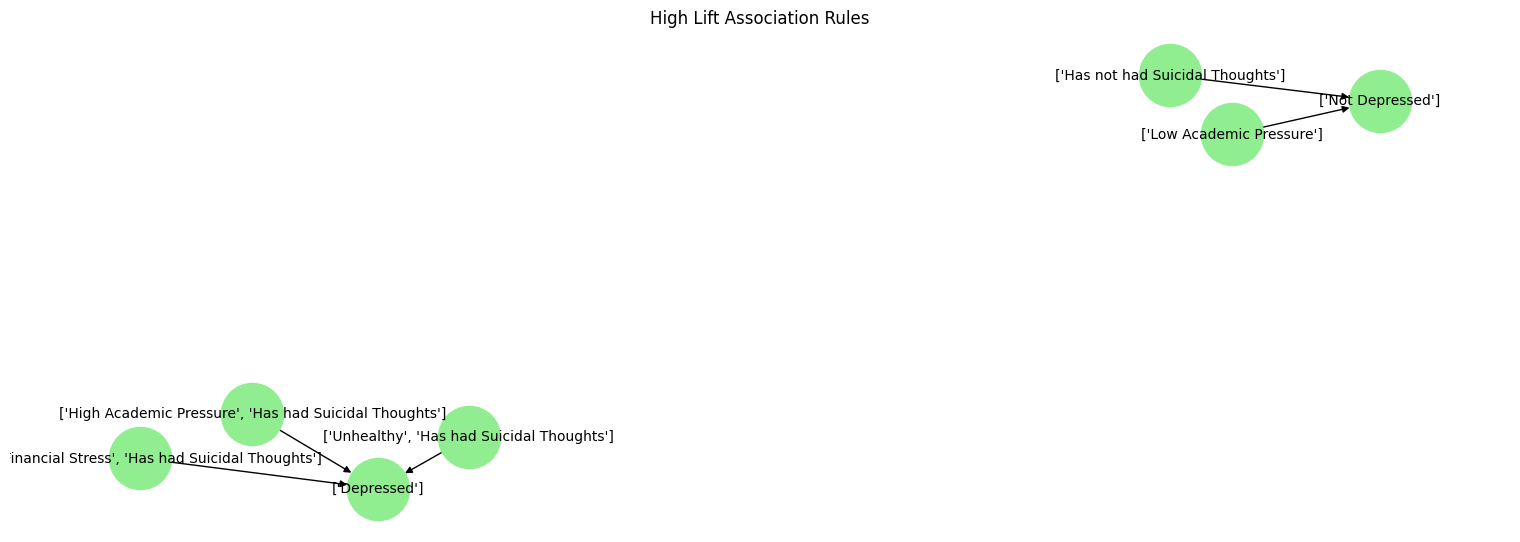

In [436]:
create_network_graph(associationRules, "High Lift Association Rules", condition=lambda rule: rule["lift"] > 1.4)

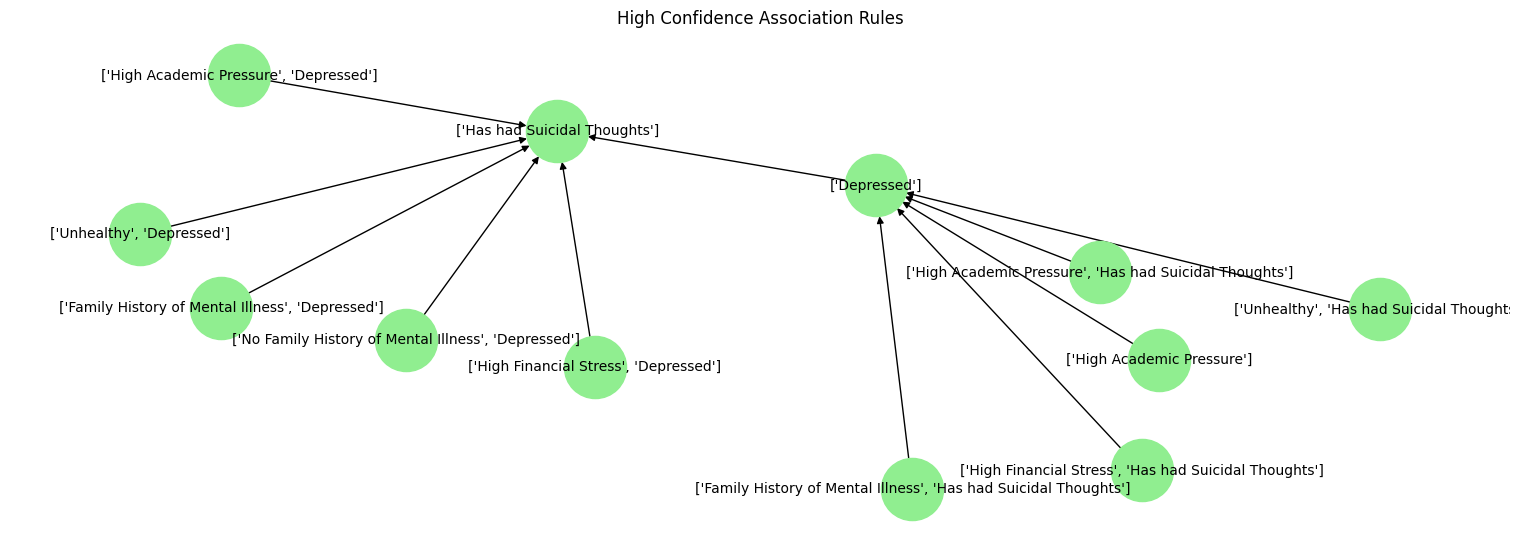

In [437]:
create_network_graph(associationRules, "High Confidence Association Rules", condition=lambda rule: rule["confidence"] > 0.8)

# 5. Classification


Preparation for classification.

In [446]:
def prepare_for_classification(df : DataFrame):
  df = df.withColumn("Depression", when(df["Depression"] == "Depressed", 1).when(df["Depression"] == "Not Depressed", 0).otherwise(None))
  df = df.na.drop()
  train, test = df.randomSplit([0.7, 0.3])

  stringColumns = ['Gender', 'Sleep Duration', 'Dietary Habits', 'Financial Stress', "Family History of Mental Illness", "Suicidal Thoughts"]
  indexers = [StringIndexer(inputCol=col, outputCol=col + "Index") for col in stringColumns]
  encoders = [OneHotEncoder(inputCol=col + "Index", outputCol=col + "Vector") for col in stringColumns]

  assembler = VectorAssembler(inputCols=['Age', 'Academic Pressure', 'CGPA', 'Study Satisfaction', 'Work/Study Hours'] + [col + "Vector" for col in stringColumns], outputCol='features')
  return train, test, indexers, encoders, assembler

In [439]:
def evaluate_model(label, results):
  print(f"ROC_AUC {BinaryClassificationEvaluator(labelCol=label).evaluate(results)}")

In [447]:
train, test, indexers, encoders, assembler = prepare_for_classification(df)

## 5.1 Logistic Regression

In [452]:
log_reg = LogisticRegression(featuresCol='features', labelCol='Depression')

logisticRegressionPipeline = Pipeline(stages=indexers + encoders + [assembler, log_reg])
lr_model = logisticRegressionPipeline.fit(train)
results = lr_model.transform(test)

results.show()

+------+---+-----------------+----+------------------+-----------------+--------------+--------------------+----------------+----------------+--------------------------------+----------+-----------+-------------------+-------------------+---------------------+-------------------------------------+----------------------+------------+--------------------+--------------------+----------------------+--------------------------------------+-----------------------+--------------------+--------------------+--------------------+----------+
|Gender|Age|Academic Pressure|CGPA|Study Satisfaction|   Sleep Duration|Dietary Habits|   Suicidal Thoughts|Work/Study Hours|Financial Stress|Family History of Mental Illness|Depression|GenderIndex|Sleep DurationIndex|Dietary HabitsIndex|Financial StressIndex|Family History of Mental IllnessIndex|Suicidal ThoughtsIndex|GenderVector|Sleep DurationVector|Dietary HabitsVector|Financial StressVector|Family History of Mental IllnessVector|Suicidal ThoughtsVector| 

**Evaluating**

In [453]:
evaluate_model("Depression", results)

ROC_AUC 0.9224227014306373


## 5.2 Random Forest

In [454]:
rf = RandomForestClassifier(featuresCol='features', labelCol='Depression')

randomForestPipeline = Pipeline(stages=indexers + encoders + [assembler, rf])
rf_model = randomForestPipeline.fit(train)
results = rf_model.transform(test)

results.show()

+------+---+-----------------+----+------------------+-----------------+--------------+--------------------+----------------+----------------+--------------------------------+----------+-----------+-------------------+-------------------+---------------------+-------------------------------------+----------------------+------------+--------------------+--------------------+----------------------+--------------------------------------+-----------------------+--------------------+--------------------+--------------------+----------+
|Gender|Age|Academic Pressure|CGPA|Study Satisfaction|   Sleep Duration|Dietary Habits|   Suicidal Thoughts|Work/Study Hours|Financial Stress|Family History of Mental Illness|Depression|GenderIndex|Sleep DurationIndex|Dietary HabitsIndex|Financial StressIndex|Family History of Mental IllnessIndex|Suicidal ThoughtsIndex|GenderVector|Sleep DurationVector|Dietary HabitsVector|Financial StressVector|Family History of Mental IllnessVector|Suicidal ThoughtsVector| 

**Evaluation**

In [455]:
evaluate_model("Depression", results)

ROC_AUC 0.9051506652220507


# 6. Prediction

In [444]:
describeDF(df)

Number of rows: 27868
root
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Academic Pressure: double (nullable = true)
 |-- CGPA: double (nullable = true)
 |-- Study Satisfaction: double (nullable = true)
 |-- Sleep Duration: string (nullable = true)
 |-- Dietary Habits: string (nullable = true)
 |-- Suicidal Thoughts: string (nullable = true)
 |-- Work/Study Hours: double (nullable = true)
 |-- Financial Stress: double (nullable = true)
 |-- Family History of Mental Illness: string (nullable = true)
 |-- Depression: string (nullable = true)



In [445]:
fakeStudent = ['Female', 24, 3.0, 7.98, 3.0, 'Less than 5 hours', 'Healthy', 'Has had Suicidal Thoughts', 10.0, 3.0, 'Family History of Mental Illness']
lr_model.transform(spark.createDataFrame([fakeStudent]*20, schema=df.drop('Depression').schema)).select(col("prediction"), col('probability')).show(truncate=False)
rf_model.transform(spark.createDataFrame([fakeStudent]*20, schema=df.drop('Depression').schema)).select(col("prediction"), col('probability')).show(truncate=False)

+----------+---------------------------------------+
|prediction|probability                            |
+----------+---------------------------------------+
|1.0       |[0.1488178004141531,0.8511821995858468]|
|1.0       |[0.1488178004141531,0.8511821995858468]|
|1.0       |[0.1488178004141531,0.8511821995858468]|
|1.0       |[0.1488178004141531,0.8511821995858468]|
|1.0       |[0.1488178004141531,0.8511821995858468]|
|1.0       |[0.1488178004141531,0.8511821995858468]|
|1.0       |[0.1488178004141531,0.8511821995858468]|
|1.0       |[0.1488178004141531,0.8511821995858468]|
|1.0       |[0.1488178004141531,0.8511821995858468]|
|1.0       |[0.1488178004141531,0.8511821995858468]|
|1.0       |[0.1488178004141531,0.8511821995858468]|
|1.0       |[0.1488178004141531,0.8511821995858468]|
|1.0       |[0.1488178004141531,0.8511821995858468]|
|1.0       |[0.1488178004141531,0.8511821995858468]|
|1.0       |[0.1488178004141531,0.8511821995858468]|
|1.0       |[0.1488178004141531,0.851182199585